# _*Qiskit Finance: qGAN Option Pricing*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Christa Zoufal<sup>[1,2]</sup>, Stefan Woerner<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ
- <sup>[2]</sup>ETH Zurich

### Introduction
We can train a quantum Generative Adversarial Network (qGAN) - see [qGANs for Loading Random Distributions](../../aqua/artificial_intelligence/qgans_for_loading_random_distributions.ipynb) - to learn and load a model for the spot price of an asset underlying a European call option. The resulting model can then be integrated into a Quantum Amplitude Estimation based algorithm to evaluate the expected payoff - see [European Call Option Pricing](../../aqua/finance/european_call_option_pricing.ipynb).

In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.components.uncertainty_problems import EuropeanCallExpectedValue
from qiskit.aqua.components.uncertainty_models import UnivariateVariationalDistribution, NormalDistribution
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua import aqua_globals, QuantumInstance

from qiskit import BasicAer

/Users/ouf/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit_terra-0.8.0-py3.7-macosx-10.7-x86_64.egg/qiskit/circuit/variabletable.py:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping


### Uncertainty Model

The Black-Scholes model assumes that the spot price at maturity $S_T$ for a European call option is log-normally distributed. Thus, we can train a qGAN on samples from a log-normal distribution, as it is shown in [qGANs for Loading Random Distributions](../../aqua/artificial_intelligence/qgans_for_loading_random_distributions.ipynb), and use the resulting model as uncertainty model underlying the option.
In the following, we construct the quantum circuit for loading the uncertainty model. The circuit output reads $$\lvert g_{\theta}\rangle = \sum\limits_{j=0}^{2^n-1}\sqrt{p_{\theta}^{j}}\lvert{j}\rangle,$$ whereby the probabilites $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, represent a model of the target distribution.

In [2]:
# Set upper and lower data values
bounds = np.array([0.,7.])
# Set number of qubits used in the uncertainty model
num_qubits = [3]

# Set entangler map
entangler_map = []
for i in range(sum(num_qubits)):
    entangler_map.append([i, int(np.mod(i+1, sum(num_qubits)))])

# Set variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, entangler_map=entangler_map, entanglement_gate='cz')
# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694,  0.07245791, 6.02626428, 0.13537225]
# Set an initial state for the generator circuit
init_dist = NormalDistribution(int(sum(num_qubits)), mu=1., sigma=1., low=bounds[0], high=bounds[1])
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, g_params,
                                              initial_distribution=init_dist, low=bounds[0], high=bounds[1])

# construct circuit factory for uncertainty model
uncertainty_model = g_circuit

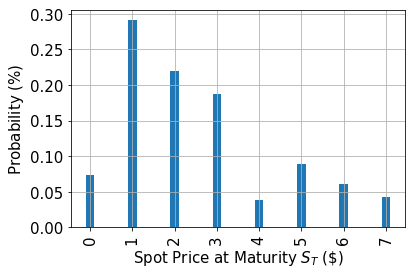

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

### Evaluate Expected Payoff
Now, the trained uncertainty model can be used as part of a quantum circuit to evaluate the expectation value of the option's payoff function.

In [8]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.25

# construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    uncertainty_model,
    strike_price=strike_price,
    c_approx=c_approx
)
# set number of evaluation qubits (samples)
m = 5

# construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))
print('Estimated value:\t%.4f' % result['estimation'])
print('Probability:    \t%.4f' % result['max_probability'])

Estimated value:	1.2580
Probability:    	0.8785
